In [1]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# import matplotlib
from tqdm import tqdm
import torch


# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
sns.set_style("darkgrid")

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [17]:
separable = False
while not separable:
    samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])


red_labels = np.zeros(len(red))
blue_labels = np.ones(len(blue))

labels = np.append(red_labels,blue_labels)
inputs = np.concatenate((red,blue),axis=0)

In [18]:
X_train, X_test, y_train,  y_test = train_test_split(
    inputs, labels, test_size=0.33, random_state=42)

In [4]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [5]:
epochs = 20000
input_dim = 2 # Two inputs x1 and x2 
output_dim = 1 # Two possible outputs
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")




Training Epochs:  53%|█████▎    | 10555/20000 [00:02<00:02, 4582.13it/s]

Iteration: 10000. 
Test - Loss: 0.014038068242371082. Accuracy: 100.0
Train -  Loss: 0.014686284586787224. Accuracy: 100.0



Training Epochs: 100%|██████████| 20000/20000 [00:04<00:00, 4544.92it/s]

Iteration: 20000. 
Test - Loss: 0.007372480351477861. Accuracy: 100.0
Train -  Loss: 0.007746598217636347. Accuracy: 100.0



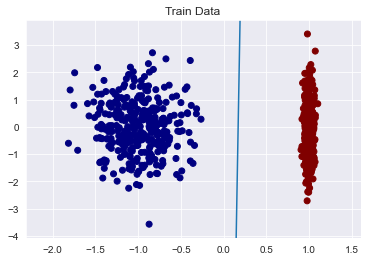

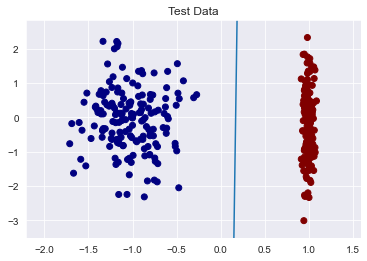

In [9]:
def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    # plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    # plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data')

In [10]:
from tensorflow import keras
print (keras.__version__)

2.4.0


In [14]:
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(2,), activation='sigmoid'))

In [15]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [20]:
model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=20,
  batch_size=16
)

Epoch 1/20
42/42 [==============================] - 0s 522us/step - loss: 0.6458 - binary_accuracy: 0.6373
Epoch 2/20
42/42 [==============================] - 0s 332us/step - loss: 0.5623 - binary_accuracy: 0.7507
Epoch 3/20
42/42 [==============================] - 0s 451us/step - loss: 0.4935 - binary_accuracy: 0.8299
Epoch 4/20
42/42 [==============================] - 0s 451us/step - loss: 0.4370 - binary_accuracy: 0.9030
Epoch 5/20
42/42 [==============================] - 0s 404us/step - loss: 0.3903 - binary_accuracy: 0.9373
Epoch 6/20
42/42 [==============================] - 0s 404us/step - loss: 0.3514 - binary_accuracy: 0.9746
Epoch 7/20
42/42 [==============================] - 0s 380us/step - loss: 0.3189 - binary_accuracy: 0.9881
Epoch 8/20
42/42 [==============================] - 0s 380us/step - loss: 0.2914 - binary_accuracy: 0.9970
Epoch 9/20
42/42 [==============================] - 0s 451us/step - loss: 0.2680 - binary_accuracy: 0.9970
Epoch 10/20
42/42 [==================

In [21]:
eval = model.evaluate(x=X_test, y=y_test)
eval

11/11 [==============================] - 0s 472us/step - loss: 0.1327 - binary_accuracy: 1.0000


[0.13271299004554749, 1.0]